## Classification of MNIST dataset with tensor networks

In [55]:
# import packages here
# --------------------------------------
import matplotlib.pyplot as plt

import qtealeaves as qtl
from qtealeaves.convergence_parameters.conv_params import TNConvergenceParameters
from qtealeaves.emulator.mps_simulator import MPS
from qtealeaves.emulator import StateVector

from tensorflow.keras.datasets import mnist
import numpy as np


### Load MNIST dataset

In [56]:
# Load dataset here
# --------------------------------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28)
(10000, 28, 28)


In [57]:
# Selecting only images with the numbers 3 and 8
train_filter = np.where((y_train == 3 ) | (y_train == 8))
test_filter = np.where((y_test == 3) | (y_test == 8))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

train_idxs_3 = np.where(y_train == 3)
train_idxs_8 = np.where(y_train == 8)
test_idxs_3 = np.where(y_test == 3)
test_idxs_8 = np.where(y_test == 8)

y_train[train_idxs_3] = 0
y_train[train_idxs_8] = 1
y_test[test_idxs_3] = 0
y_test[test_idxs_8] = 1

# Reduce amount of images
nr_images = 500

x_train, y_train, x_test, y_test = x_train[:nr_images, :, :], y_train[:nr_images], x_test[:nr_images, :, :], y_test[:nr_images]

x_train = x_train / 255
x_test = x_test / 255

In [58]:
def encoding1(array: np.array):
    new_array = np.zeros((array.shape[0],2))
    for i in range(len(array)):
        p_i = np.sqrt(array[i])
        new_array[i] = (np.sqrt(1-np.square(p_i)), p_i)
    foo2 = np.expand_dims(new_array, axis = (1, -1))
    foo3 = []
    for i in range(foo2.shape[0]):
        foo3.append(foo2[i, :, :, :])
    return foo3

# Testing
foo = np.random.rand(16)
foo3 = encoding1(foo)
len(foo3)

16

In [59]:
def encoding3(array: np.array):
    new_array = np.zeros((array.shape[0],2))
    for i in range(len(array)):
        p_i = np.sqrt(array[i])
        new_array[i] = (np.cos(p_i), np.sin(p_i))
    foo2 = np.expand_dims(new_array, axis = (1, -1))
    foo3 = []
    for i in range(foo2.shape[0]):
        foo3.append(foo2[i, :, :, :])
    return foo3

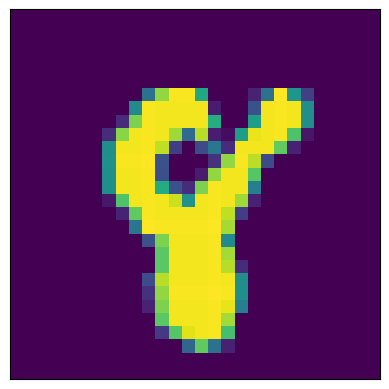

In [60]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0, :, :])
plt.xticks([], [])
plt.yticks([], [])
plt.savefig('figs/n3.pdf')

plt.imshow(x_train[400, :, :])
plt.xticks([], [])
plt.yticks([], [])
plt.savefig('figs/n8.pdf')

In [61]:
import skimage.measure

x_train = skimage.measure.block_reduce(x_train, (1,7, 7), np.mean)
x_test = skimage.measure.block_reduce(x_test, (1,7,7), np.mean)

x_train.shape




(500, 4, 4)

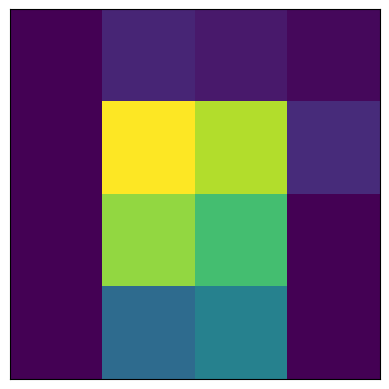

In [62]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0, :, :])
plt.xticks([], [])
plt.yticks([], [])
plt.savefig('figs/n3_coarse.pdf')

plt.imshow(x_train[400, :, :])
plt.xticks([], [])
plt.yticks([], [])
plt.savefig('figs/n8_coarse.pdf')

In [63]:
# Flatten image
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]))

x_test.shape

(500, 16)

### Build classifier


In [64]:
# Convert dataset into a list of MPS
# --------------------------------------
X_train_mps = []
X_test_mps = []

encoding  = 1       # Either 1 or 2

if encoding == 1:
    for i in range(x_test.shape[0]):
        X_train_mps.append(MPS.from_tensor_list(encoding1(x_train[i, :]), conv_params=TNConvergenceParameters()))
        X_test_mps.append(MPS.from_tensor_list(encoding1(x_test[i]), conv_params=TNConvergenceParameters()))
elif encoding == 2:
    for i in range(x_test.shape[0]):
        X_train_mps.append(MPS.from_statevector(x_train[i, :], conv_params=TNConvergenceParameters()))
        X_test_mps.append(MPS.from_statevector(x_test[i], conv_params=TNConvergenceParameters()))
elif encoding == 3:
    for i in range(x_test.shape[0]):
        X_train_mps.append(MPS.from_tensor_list(encoding3(x_train[i, :]), conv_params=TNConvergenceParameters()))
        X_test_mps.append(MPS.from_tensor_list(encoding3(x_test[i]), conv_params=TNConvergenceParameters()))



==================== Sweep 0 started ====================
Sweep loss: 1.7197737437677778
==================== Sweep 1 started ====================
Sweep loss: 2.5802801478229997
==================== Sweep 2 started ====================
Sweep loss: 1.8795429704861513
==================== Sweep 3 started ====================
Sweep loss: -0.12280094098750668
==================== Sweep 4 started ====================
Sweep loss: 2.8671829314873354
==================== Sweep 5 started ====================
Sweep loss: 2.202702261080964
==================== Sweep 6 started ====================
Sweep loss: 3.184663736510841
==================== Sweep 7 started ====================
Sweep loss: 2.939008848419343
==================== Sweep 8 started ====================
Sweep loss: 2.7087839338281685
==================== Sweep 9 started ====================
Sweep loss: 2.922520445110063
==================== Sweep 10 started ====================
Sweep loss: 2.4354788200133566
==================== S

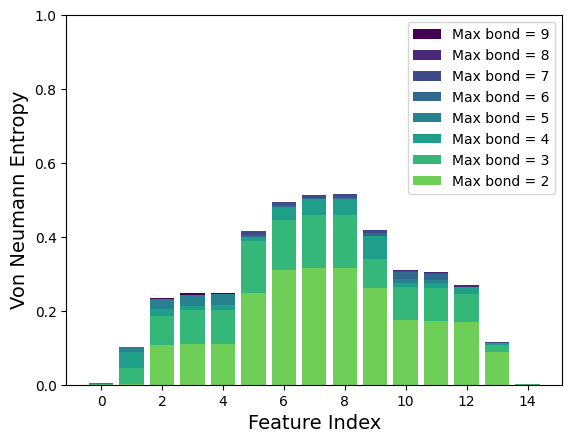

In [67]:
from matplotlib.ticker import MaxNLocator

# This cell is for looping over the max bond dimension

# Optimize MPS

# num sites
if encoding == 1 or encoding == 3:
    num_sites = x_train.shape[1]
elif encoding == 2: 
    num_sites = int(np.log2(x_train.shape[1]))


# define batch size, learning rate and number of sweeps
batch_size = 50
learning_rate = 1e-4
num_sweeps = 1000   # epochs

max_bond_array = np.flip(np.arange(2,10))
accuracies = []

# define mus outside of loop
mus = np.arange(1,1000,100)
cmap = plt.cm.viridis
i = 0

colors = []

for max_bond_value in max_bond_array:

    color = cmap(mus[i]/np.max(mus))
    i += 1 
    colors.append(color)
    max_bond = int(max_bond_value)
    # initialize MPS for the classifier
    conv_params = TNConvergenceParameters(
                        max_bond_dimension=max_bond)
    tn_classifier = MPS(num_sites, conv_params, dtype=float)

    svd, loss = tn_classifier.ml_optimize_mps(X_train_mps,
                                    y_train,
                                    batch_size=batch_size,
                                    learning_rate=learning_rate,
                                    num_sweeps=num_sweeps,
                                    n_jobs=1,
                                    verbose=True)

    # Predict labels with the trained MPS
    y_train_pred = tn_classifier.ml_predict(X_train_mps, n_jobs=1)
    y_test_pred = tn_classifier.ml_predict(X_test_mps, n_jobs=1)

    # Get accuracy
    accuracy_train = len(np.where(y_train == np.real(y_train_pred))[0]) / len(y_train)
    print(accuracy_train)

    accuracy_test = len(np.where(y_test == np.real(y_test_pred))[0]) / len(y_test)
    print(accuracy_test)
    accuracies.append(accuracy_test)

    tn_classifier.normalize()
    tn_classifier.iso_towards(0, trunc = True)
    tn_classifier.iso_towards(tn_classifier.num_sites-1, trunc = True)
    entropy = tn_classifier.meas_bond_entropy()
    entropy_l = entropy.values()
    x_array = np.arange(len(entropy_l))
    plt.bar(x_array, np.array(list(entropy_l)), alpha=1, color = color, label = "Max bond = " + str(max_bond))
    plt.ylim(0,1)
    plt.ylabel('Von Neumann Entropy', fontsize = 14)
    plt.xlabel('Feature Index', fontsize = 14)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True))
    # plt.savefig('figs/entropy_enc2_max_bond_' + str(max_bond) + '_.png')
    # plt.close()
# Define a scalar mappable for the colorbar with your custom colormap
# colors = ListedColormap(colors)
# sm = plt.cm.ScalarMappable(cmap=colors)
# sm.set_array([])  # Set the array to empty because we don't use it directly
# # Add the colorbar to the figure
# cbar = plt.colorbar(sm,  orientation='vertical')
# cbar.set_label('Custom Colorbar')
plt.legend()
plt.savefig('figs/entropy_enc1_max_bond.png')


In [ ]:
plt.plot(accuracies, color = 'k', lw = 3)
plt.ylabel('Test Accuracy', fontsize = 14)
plt.xlabel('Max bond dimension', fontsize = 14)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True))
plt.savefig('max_bond_enc2.png')


In [ ]:
# Optimize MPS

# num sites
if encoding == 1 or encoding == 3:
    num_sites = x_train.shape[1]
elif encoding == 2: 
    num_sites = int(np.log2(x_train.shape[1]))

# define max bond dimension
max_bond = 10

# define batch size, learning rate and number of sweeps
batch_size = 50
learning_rate = 1e-4
num_sweeps = 1000    # epochs

# initialize MPS for the classifier
conv_params = TNConvergenceParameters(
                    max_bond_dimension=max_bond)
tn_classifier = MPS(num_sites, conv_params, dtype=float)

svd, loss = tn_classifier.ml_optimize_mps(X_train_mps,
                                y_train,
                                batch_size=batch_size,
                                learning_rate=learning_rate,
                                num_sweeps=num_sweeps,
                                n_jobs=1,
                                verbose=True)

### Prediction on train and test dataset

In [ ]:
# Predict labels with the trained MPS
y_train_pred = tn_classifier.ml_predict(X_train_mps, n_jobs=1)
y_test_pred = tn_classifier.ml_predict(X_test_mps, n_jobs=1)

In [ ]:
plt.plot(loss, lw = 2)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Sweeps', fontsize=14)
#plt.savefig('loss_enc3.png')

In [ ]:
# Get accuracy
accuracy_train = len(np.where(y_train == np.real(y_train_pred))[0]) / len(y_train)
print(accuracy_train)

accuracy_test = len(np.where(y_test == np.real(y_test_pred))[0]) / len(y_test)
print(accuracy_test)

In [ ]:
entropy = tn_classifier.meas_bond_entropy()
entropy_l = entropy.values()
x_array = np.arange(len(entropy_l))
plt.bar(x_array, -np.array(list(entropy_l)))
plt.ylabel('Von Neumann Entropy', fontsize = 14)
plt.xlabel('Feature Index', fontsize = 14)
#plt.savefig('entropy_enc3.png')


# 

Questions:

* How to interpret the entropy ? 
* Which range of bond dimensions to consider ? 